# Fit Spikes Dev, Get Uniform Input Working

In [1]:
import numpy as np
from brian2 import *
from brian2tools import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Get Neuron Spikes to Model

In [2]:
dt = 0.01 * ms
defaultclock.dt = dt
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)*5), np.zeros(5*int(5*ms/dt))])* 5 * nA
I = TimedArray(input_current, dt=dt)

In [3]:
# C = 1*nF
# gL = 30*nS
EL = -70*mV
VT = -50*mV
DeltaT = 2*mV
eqs = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I(t))/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''')

In [4]:
group = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')
group.v = -70 *mV
group.set_states({'gL': [30*nS], 'C':[1*nF]})

In [5]:
monitor = StateMonitor(group, 'v', record=True)
smonitor  = SpikeMonitor(group)

In [6]:
run(60*ms)

#### Get Output

In [7]:
voltage = monitor.v[0]/mV
out_spikes = getattr(smonitor, 't') / ms
print(out_spikes)

[ 9.24 13.5  17.76 22.02 26.28]


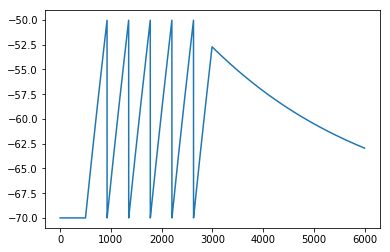

In [8]:
plot(voltage);

## Fitting

In [9]:
start_scope()
eqs_fit = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I)/C : volt
    gL: siemens (constant)
    ''',
    EL = -70*mV,
    VT = -50*mV,
    DeltaT = 2*mV,
    C=1*nF)

n_opt = NevergradOptimizer()
metric = GammaFactor(100*ms, dt)
inp_trace = np.array([input_current])

In [10]:
TR = fit_spikes(model=eqs_fit, input_var='I',
                    input=inp_trace * amp, output=out_spikes, dt=dt,
                    n_rounds=1, n_samples=5, optimizer=n_opt, metric=metric,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler',
                    param_init={'v': -70*mV},
                    gL=[20*nS, 40*nS],
                    # C = [0.5*nS, 1.5*nS]
                    )

In [11]:
TR

{0: array([ 9.17, 13.36, 17.55, 21.74, 25.93]) * msecond,
 1: array([ 9.26, 13.54, 17.82, 22.1 , 26.38]) * msecond,
 2: array([ 9.26, 13.54, 17.82, 22.1 , 26.38]) * msecond,
 3: array([ 9.21, 13.44, 17.67, 21.9 , 26.13]) * msecond,
 4: array([ 9.28, 13.58, 17.88, 22.18, 26.48]) * msecond}

#### Switch to 2D array of results

In [12]:
traces = []
for i in np.arange(len(TR)):
    trace = TR[i] / ms
    traces.append(trace)

In [13]:
traces = np.array(traces)    
traces

array([[ 9.17, 13.36, 17.55, 21.74, 25.93],
       [ 9.26, 13.54, 17.82, 22.1 , 26.38],
       [ 9.26, 13.54, 17.82, 22.1 , 26.38],
       [ 9.21, 13.44, 17.67, 21.9 , 26.13],
       [ 9.28, 13.58, 17.88, 22.18, 26.48]])

## Calculate the Gamma Factor

In [14]:
def firing_rate(spikes):
    '''
    Rate of the spike train.
    '''
    if len(spikes)<2:
        return NaN
    return (len(spikes) - 1) / (spikes[-1] - spikes[0])

In [15]:
def get_gamma_factor(source, target, delta, dt):
    """Calculate gamma factor between source and tagret spike trains"""
    source = array(source)
    target = array(target)
    target_rate = firing_rate(target) * Hz

    source = array(rint(source / dt), dtype=int)
    target = array(rint(target / dt), dtype=int)
    delta_diff = int(rint(delta / dt))

    source_length = len(source)
    target_length = len(target)

    if (source_length > 1):
        bins = .5 * (source[1:] + source[:-1])
        indices = digitize(target, bins)
        diff = abs(target - source[indices])
        matched_spikes = (diff <= delta_diff)
        coincidences = sum(matched_spikes)
    else:
        indices = [amin(abs(source - target[i])) <= delta_diff for i in xrange(target_length)]
        coincidences = sum(indices)

    # Normalization of the coincidences count
    NCoincAvg = 2 * delta * target_length * target_rate
    norm = .5*(1 - 2 * target_rate * delta)
    gamma = (coincidences - NCoincAvg)/(norm*(source_length + target_length))
    return gamma

In [22]:
gamma_facts = []
for trace in traces:
    gf = get_gamma_factor(trace, out_spikes, 60*ms, dt)
    gamma_facts.append(gf)

In [23]:
gamma_facts

[-0.028985507246376812,
 0.5884057971014492,
 0.5884057971014492,
 0.38260869565217387,
 0.17681159420289855]

In [24]:
print(out_spikes)
print(traces)

[ 9.24 13.5  17.76 22.02 26.28]
[[ 9.17 13.36 17.55 21.74 25.93]
 [ 9.26 13.54 17.82 22.1  26.38]
 [ 9.26 13.54 17.82 22.1  26.38]
 [ 9.21 13.44 17.67 21.9  26.13]
 [ 9.28 13.58 17.88 22.18 26.48]]
